In [1]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.exceptions import ConvergenceWarning
import warnings
import itertools
import json


In [67]:
MAX_INT_TOKEN = {
    'gpt-j-6B': 361,
    'Llama-3.1-8B': 999,
    'pythia-6.9b': 557    
}
OPERATION = 'multiplication'
assert OPERATION in ['addition', 'multiplication']


# Load the model

In [2]:
# Load model# Set the token as an environment variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

# Generate Expressions and Evaluate the Model

In [90]:
np.random.seed(42)
def gen_math(mina = 0, maxa = 99):
    """Generates the questions and expected answers for the addition problem"""
    data = []
    with torch.no_grad():
        for a in tqdm(range(mina, maxa + 1)):
            for b in range(mina, maxa + 1):
                if OPERATION == 'multiplication':
                    op = "*"
                else:
                    op = "+"
                if MODEL_NAME == 'gpt-j-6B':
                    q_string = f'Output ONLY a number.\n{a}{op}{b}='
                elif MODEL_NAME == 'Llama-3.1-8B':
                    q_string = f'The following is a correct {OPERATION} problem. \n{a}{op}{b}='
                elif MODEL_NAME == 'pythia-6.9b':
                    q_string = f'Output ONLY a number. {a}{op}{b}='
                q_toks = model.tokenizer(q_string)['input_ids']
                if OPERATION == 'multiplication':
                    answer = a*b
                    if answer > MAX_INT_TOKEN[MODEL_NAME]:
                        continue
                else:
                    answer = a+b
                answer_tok = model.tokenizer(f'{answer}')['input_ids']
                if MODEL_NAME == 'Llama-3.1-8B':
                    answer_tok = [answer_tok[-1]]
                #print(answer_tok)
                data.append({
                    'a': a,
                    'b': b,
                    'q_string': q_string,
                    'q_tok': q_toks,
                    'answer': answer,
                    'answer_tok': answer_tok
                })
    df = pd.DataFrame(data)
    df.to_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df


#evaluate_math(mina = 0, maxa = 500)
gen_math(mina = 0, maxa = 99)
#data = get_math_gen()

100%|██████████| 100/100 [00:00<00:00, 216.62it/s]


,a,b,q_string,q_tok,answer,answer_tok
0,0,0,Output ONLY a number.\n0*0=,"[26410, 22224, 257, 1271, 13, 198, 15, 9, 15, 28]",0,[15]
1,0,1,Output ONLY a number.\n0*1=,"[26410, 22224, 257, 1271, 13, 198, 15, 9, 16, 28]",0,[15]
2,0,2,Output ONLY a number.\n0*2=,"[26410, 22224, 257, 1271, 13, 198, 15, 9, 17, 28]",0,[15]
3,0,3,Output ONLY a number.\n0*3=,"[26410, 22224, 257, 1271, 13, 198, 15, 9, 18, 28]",0,[15]
4,0,4,Output ONLY a number.\n0*4=,"[26410, 22224, 257, 1271, 13, 198, 15, 9, 19, 28]",0,[15]
...,...,...,...,...,...,...
1655,98,3,Output ONLY a number.\n98*3=,"[26410, 22224, 257, 1271, 13, 198, 4089, 9, 18...",294,[27696]
1656,99,0,Output ONLY a number.\n99*0=,"[26410, 22224, 257, 1271, 13, 198, 2079, 9, 15...",0,[15]
1657,99,1,Output ONLY a number.\n99*1=,"[26410, 22224, 257, 1271, 13, 198, 2079, 9, 16...",99,[2079]
1658,99,2,Output ONLY a number.\n99*2=,"[26410, 22224, 257, 1271, 13, 198, 2079, 9, 17...",198,[22337]


  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:01<00:00, 10.32it/s, %=0.989]


Accuracy for numbers up to 25: 84.68%
Accuracy for numbers up to 50: 82.01%
Accuracy for numbers up to 75: 80.84%
Accuracy for numbers up to 100: 79.65%


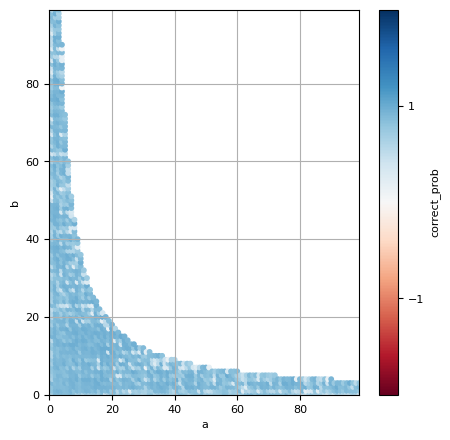

In [97]:
def evaluate_math(mina = 0, maxa = 99, verbose = False, batch_size = 100):
    """Evaluates the model on the addition problem, and just record if it was correct or not (per batch)."""
    df = pd.read_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_{mina}_{maxa}_{MODEL_NAME}.pkl')
    #df = df.sample(n=15, random_state=42)
    corrects = []
    correct_probs = []
    with torch.no_grad():
        # Process rows in batches
        bar = tqdm(range(0, len(df), batch_size))
        for step in bar:
            batch_df = df.iloc[step:min(step + batch_size, len(df))]
            batch_toks = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
            # Combine into single batch tensor
            answer_toks = torch.stack([torch.tensor(x)[0] for x in batch_df['answer_tok'].values])
            # Get model outputs for batch
            with model.trace() as tracer:
                with tracer.invoke(batch_toks) as invoker:
                    pass
                output = model.output.save()
            
            # Get predictions for batch
            logits = output.logits[:,-1].cpu()
            #print(model.tokenizer.batch_decode(output.logits[0].argmax(dim=-1)))
            model_answers = logits.argmax(dim=-1)
            probs = torch.softmax(logits, -1)

            correct = (model_answers == answer_toks).float()
            correct_prob = torch.gather(probs, -1, answer_toks[:,None])[:, 0]
            #correct = probs[:, answer_toks]
            incorrect_mask = correct == 0
            if incorrect_mask.any() and verbose:
                print("Incorrect answers:")
                print("Expected:", model.tokenizer.batch_decode(answer_toks[incorrect_mask].unsqueeze(-1)))
                print("Got:", model.tokenizer.batch_decode(model_answers[incorrect_mask].unsqueeze(-1)))
            corrects.extend(list(correct))
            correct_probs.extend(list(correct_prob))
            bar.set_postfix({'%': np.mean(corrects)})
            
    df['correct'] = corrects
    df['correct_prob'] = correct_probs
    df.to_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return np.mean(corrects)

def plot_math_results(mina = 0, maxa = 99):    
    model_name = MODEL_NAME
    df = pd.read_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')

    plot_type = 'correct_prob'#'correct'
    
    # Print accuracies for different ranges
    for max_val in [25, 50, 75, 100]:
        filtered_df = df[(df['a'] <= max_val) & (df['b'] <= max_val)]
        acc = 100 * np.mean(filtered_df[plot_type])
        print(f"Accuracy for numbers up to {max_val}: {acc:.2f}%")
    
    plt.figure(figsize=(5, 5))
    # Create a scatter plot
    scatter = plt.scatter(df['a'], df['b'], c=df[plot_type].replace({1: 1, 0: -1}), cmap='RdBu', s=10, vmin = -2, vmax = 2)
    # Add colorbar
    plt.colorbar(scatter, ticks=[-1, 1], label=plot_type)
    # plt.title(f'{model_name} Results on a+b= (Blue if correct)\n{100*np.mean(df['correct']):.2f}% Correct')
    plt.xlabel('a')
    plt.ylabel('b')
    plt.xlim(mina, maxa)
    plt.ylim(mina, maxa)
    plt.grid(True)
    plt.show()


evaluate_math(mina = 0, maxa = 99, verbose = False)
plot_math_results()

# Helper Functions to get the Correct Data

In [98]:
def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df[df['correct'] == 1]

def get_df_sample(mina = 0, maxa = 99, num_sample = 500, run = False):
    if run:
        df = get_correct_df(mina, maxa)
        df = df.sample(n=num_sample, random_state=42).reset_index(drop=True)
        # Save sampled dataframe
        save_path = f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl'
        df.to_pickle(save_path)
    return pd.read_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl')

def get_output_tokens(mina = 0, maxa = 99):
    # answers range from 0, 99 * 2 
    avals, toks = [], []
    for a in range(mina, 2 * maxa + 1):
        atok = model.tokenizer(f'{a}')['input_ids']
        avals.append(a)
        toks.append(atok[0])
    return avals, toks

a, toks = get_output_tokens()
get_df_sample(run = True)


,a,b,q_string,q_tok,answer,answer_tok,correct,correct_prob
0,8,5,Output ONLY a number.\n8*5=,"[26410, 22224, 257, 1271, 13, 198, 23, 9, 20, 28]",40,[1821],tensor(1.),tensor(0.9146)
1,46,2,Output ONLY a number.\n46*2=,"[26410, 22224, 257, 1271, 13, 198, 3510, 9, 17...",92,[5892],tensor(1.),tensor(0.9573)
2,18,3,Output ONLY a number.\n18*3=,"[26410, 22224, 257, 1271, 13, 198, 1507, 9, 18...",54,[4051],tensor(1.),tensor(0.8709)
3,6,48,Output ONLY a number.\n6*48=,"[26410, 22224, 257, 1271, 13, 198, 21, 9, 2780...",288,[25270],tensor(1.),tensor(0.9538)
4,53,2,Output ONLY a number.\n53*2=,"[26410, 22224, 257, 1271, 13, 198, 4310, 9, 17...",106,[15801],tensor(1.),tensor(0.9281)
...,...,...,...,...,...,...,...,...
495,43,4,Output ONLY a number.\n43*4=,"[26410, 22224, 257, 1271, 13, 198, 3559, 9, 19...",172,[23628],tensor(1.),tensor(0.9074)
496,0,31,Output ONLY a number.\n0*31=,"[26410, 22224, 257, 1271, 13, 198, 15, 9, 3132...",0,[15],tensor(1.),tensor(0.7290)
497,16,0,Output ONLY a number.\n16*0=,"[26410, 22224, 257, 1271, 13, 198, 1433, 9, 15...",0,[15],tensor(1.),tensor(0.6628)
498,2,11,Output ONLY a number.\n2*11=,"[26410, 22224, 257, 1271, 13, 198, 17, 9, 1157...",22,[1828],tensor(1.),tensor(0.8721)


# Helper function to get hidden states

In [ ]:
ANS_SEQPOS_DICT = {'a': -4, 'b':-2, 'a+b':-1}
def run_hs(target, mina = 0, maxa = 99, batch_size = 80, sample = False):
    """Gets the hidden states for the target token."""
    ANS_SEQPOS = ANS_SEQPOS_DICT[target]
    if sample:
        df = get_df_sample(mina, maxa, run = False)
    else:
        df = get_correct_df(mina, maxa)
    a = torch.tensor(df['a'].values)
    b = torch.tensor(df['b'].values)
    a_b = a+b
    hss = []
    with torch.no_grad():
        for step in tqdm(range(0, len(df), batch_size)):
            batch_df = df.iloc[step:min(step + batch_size, len(df))]
            tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
            layer_hss = []
            with model.trace(validate=False,remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    for layer in range(NLAYERS):
                        if MODEL_NAME == 'Llama-3.1-8B':
                            hs = model.model.layers[layer].input
                        elif MODEL_NAME == 'gpt-j-6B':
                            hs = model.transformer.h[layer].inputs[1]['hidden_states']
                        elif MODEL_NAME == 'pythia-6.9b':
                            hs = model.gpt_neox.layers[layer].input
                        layer_hss.append(hs[:,ANS_SEQPOS].save())
            layer_hss = [layer_hs.detach().cpu() for layer_hs in layer_hss] # gets hs on top of ans_token
            layer_hss = torch.stack(layer_hss, dim=1) # stack along new layer dimension
            hss.append(layer_hss)
    hss = torch.cat(hss, dim=0) # concat along batch dimension
    # Save nums and hss to file with descriptive name
    # Use _FULL in filename if using complete dataset
    suffix = '_FULL' if not sample else ''
    save_path = f'data_{OPERATION}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    # Create directory if it doesn't exist
    os.makedirs(f'data_{OPERATION}/helix_hss', exist_ok=True)
    # Save tensors
    torch.save({
        'a': a,
        'b':b,
        'a+b':a_b,
        'hidden_states': hss
    }, save_path)
    return a,b,a_b, hss

def get_nums_hss(target, mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'data_{OPERATION}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

# run_hs('a', sample = False)
# run_hs('a', sample = True)
# run_hs('b', sample = False)
# run_hs('b', sample = True)
# run_hs('a+b', sample = False)
# run_hs('a+b', sample = True)
get_nums_hss('a', sample = True)

100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


(tensor([ 8, 46, 18,  6, 53, 20, 87, 43, 35,  2,  4, 87, 21, 92,  8,  4,  4,  5,
         23,  6,  5,  8, 26, 61,  6, 52,  4,  4, 13,  0, 10,  2, 21,  3, 55, 73,
          9,  2,  0, 38,  2, 15,  6,  0,  3, 63,  5,  5,  2,  3,  3, 29,  5, 15,
         27,  4,  3,  4,  0,  6, 28,  1, 15,  0,  2,  0, 22,  1,  4, 96, 20, 32,
         60, 29,  3, 14, 65, 42,  0, 56,  0, 47, 29, 65,  2, 44, 30, 13, 68,  1,
         25, 18, 26,  2,  0,  3,  5, 45, 10,  9,  8, 29, 14, 31, 44, 95, 21,  9,
          6, 27,  4, 10,  3, 15, 91, 35, 48, 42, 38,  6, 39,  2,  0, 27, 34, 10,
          4,  9, 97,  3, 22, 12, 12,  4,  1,  7,  8,  4,  8, 95, 11,  0,  1,  4,
         17,  6, 16, 17,  2, 27,  0,  0, 54,  3,  1,  3, 36, 40,  1, 20,  1,  8,
         25,  6, 83,  2, 62,  6, 57, 10,  0,  4, 12,  1,  3, 58, 20, 65,  6, 51,
          7, 33,  7, 11, 75, 82,  1, 49,  4,  4, 11, 82, 19, 74,  5, 48, 12,  4,
          3, 12, 22,  4,  9,  2, 70, 28,  4, 44, 15, 36, 10,  3, 47, 20,  6,  2,
         12, 46,  1, 25, 43,

# PCA Functions
These functions generate the PCA for all hidden states to be used for helix fitting and downstream interventions

In [ ]:
def run_pca(target, mina = 0, maxa = 99, NUM_PCA = 100):
    _,_,_, hss = get_nums_hss(target, mina, maxa) # we want the full thing for a pca
    pca_components = {}
    for layer in tqdm(range(hss.shape[1])):
        hs = hss[:,layer]
        # Convert to numpy for sklearn
        hs_numpy = hs.float().numpy()
        # Fit PCA without dimensionality reduction
        pca = PCA(n_components=NUM_PCA)# None
        pca.fit(hs_numpy)
        # Store components for this layer
        pca_components[layer] = {
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'components': pca.components_,
            'singular_values': pca.singular_values_,
            'mean': pca.mean_
        }
    # Save PCA components to file with descriptive name
    save_path = f'data_{OPERATION}/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    # Create directory if it doesn't exist
    os.makedirs(f'data_{OPERATION}/helix_pca', exist_ok=True)
    # Save dictionary
    torch.save(pca_components, save_path)
    return pca_components

def get_pca(target, layer, mina = 0, maxa = 99):
    save_path = f'data_{OPERATION}/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    pca_data = torch.load(save_path, weights_only = False)[layer]
    return pca_data

# run_pca('a')
# run_pca('b')
get_pca('b', 18)

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


{'explained_variance_ratio': array([0.17692149, 0.08501832, 0.0529253 , 0.0450492 , 0.04151998,
        0.032093  , 0.03170737, 0.02610566, 0.02300501, 0.02289049,
        0.02227031, 0.02093985, 0.01926958, 0.01831   , 0.01757642,
        0.01653436, 0.01542382, 0.01472253, 0.01431667, 0.01365603,
        0.01236595, 0.01202736, 0.01112968, 0.01043801, 0.00982575,
        0.00961995, 0.00925916, 0.00914147, 0.00841597, 0.00806889,
        0.00748363, 0.00728532, 0.00709398, 0.00674028, 0.00631139,
        0.00576926, 0.00552826, 0.00537802, 0.00511302, 0.00490674,
        0.00440692, 0.00415979, 0.00404833, 0.00382739, 0.00362641,
        0.0035704 , 0.00331959, 0.00329168, 0.00304766, 0.00289085,
        0.00275073, 0.00260976, 0.0025603 , 0.00240729, 0.00225627,
        0.00213486, 0.00207169, 0.00200184, 0.00195177, 0.00190705,
        0.00183363, 0.00177061, 0.00164306, 0.00157693, 0.00153364,
        0.00145639, 0.00143901, 0.0014005 , 0.00133079, 0.00129022,
        0.00123555, 

In [105]:
def get_pca_coords(target, layer, mina = 0, maxa = 99, npca = False, reconstruction = False):
    """Expresses hidden states of target at layer in PCA space.
    npca: filter to top components
    reconstruction: reconstruct hidden states from PCA space.
    """
    assert isinstance(npca, bool) or isinstance(npca, int), "npca must be either False or an integer"
    a,b,a_b, hss = get_nums_hss(target, mina, maxa, sample = True) # just take subset
    hss = hss[:,layer]
    pca_data = get_pca(target, layer, mina, maxa)
    pca_comps, pca_mean = pca_data['components'], pca_data['mean']
    #print(hss.shape, pca_comps.shape)
    #assert hss.shape[0] == pca_comps.shape[0] # same batch
    # Project data into PCA space
    hs_numpy = hss.float().numpy()
    hs_centered = hs_numpy - pca_mean
    pca_coords = np.dot(hs_centered, pca_comps.T)
    if npca is False:
        npca = hss.shape[0] # make it full batch
    pca_coords = pca_coords[:, :npca]
    if reconstruction:
        reconstruction = torch.tensor(np.dot(pca_coords, pca_comps[:npca]) + pca_mean)
        mse = torch.mean((reconstruction - hss) ** 2)
        #print(f"MSE between reconstruction and original hidden states: {mse:.6f}")
        return a,b,a_b, reconstruction
    else:
        return a,b,a_b, pca_coords

s = get_pca_coords('a', 5, npca = 3, reconstruction=True)

# Helix Time

In [21]:
def create_features(fit_type, nums, bases = [2,5,10,100], polybase = 9):
    """creates the basis of features of helix regression (and other regression types)"""
    assert fit_type in ['helix', 'poly', 'circle', 'loghelix', 'logcircle', 'logpoly']
    feature_list = []
    for i, num in enumerate(nums):
        mnum = max(num)
        scaled_num = num / mnum
        if fit_type == 'helix' or fit_type == 'circle':
            for base in bases:
                t_scaled = 2 * np.pi * num / base
                feature_list.extend([np.cos(t_scaled), np.sin(t_scaled)])
        if fit_type == 'helix':
            feature_list.append(scaled_num)  # Add linear term for helix
        if fit_type == 'poly':
            feature_list = [num**power for power in range(1,polybase + 1)]
        if fit_type == 'loghelix' or fit_type == 'logcircle':
            for base in bases:
                t_scaled = 2 * np.pi * np.log(num) / base
                feature_list.extend([np.cos(t_scaled), np.sin(t_scaled)])
        if fit_type == 'loghelix':
            feature_list.append(np.log(scaled_num))
        if fit_type == 'logpoly':
            feature_list = [np.log(num)**power for power in range(1,polybase + 1)]
    feature_list.append(np.ones(nums.shape[1])) # bias term
    helix_features = np.column_stack(feature_list)
    return helix_features



In [27]:
def get_train_test_split(frac=0.75):
    """Returns which values of a (0-99) are in train vs test sets"""
    a_values = np.arange(100)
    n_train = int(100 * frac)
    train_a = np.random.choice(a_values, size=n_train, replace=False)
    return train_a

def get_train_mask(a, frac = 0.75):
    train_a = get_train_test_split(frac)
    """Returns boolean mask indicating which elements of a are in training set"""
    return np.isin(a, train_a)

def helix_fit(layer, helix_type, bases=[2,5,10,100], polybase=9, save=True, traintest=False, random=False):
    """Performs linear regression for a specific layer, fit_type and target.
       The dependent variables, the "features" are a simple functions of the input numbers.
       The independent variables are the hidden states of the target token, reduced to a PCA space.
      ."""
    # target is whatever comes after helix_ in helix_type
    # fitting the helix
    fit_type, target = helix_type.split('_', 1)
    a,b,a_b, hss_projected_n = get_pca_coords(target, layer, mina=0, maxa=99, npca=False, reconstruction=False)
    hss_original = get_nums_hss(target, mina=0, maxa=99)[-1][:,layer]
    pca_data = get_pca(target, layer, mina=0, maxa=99)
    pca_comp, pca_mean = pca_data['components'], pca_data['mean']

    if target == 'a_b':
        nums = np.array([a,b])
    elif target == 'a':
        nums = np.array([a])
    elif target == 'b':
        nums = np.array([b])
    helix_features = create_features(fit_type, nums, bases=bases, polybase=polybase)
    
    # Split data for train/test if requested
    train_mask = None
    if traintest:
        train_mask = get_train_mask(a)
        train_features = helix_features[train_mask]
        train_targets = hss_projected_n[train_mask]
    else:
        train_features = helix_features
        train_targets = hss_projected_n
    
    if random:
        np.random.shuffle(train_features)
    #print(train_features)
        
    # Fit a separate linear model for each reduced dimension
    weights_by_dim = []
    predictions = np.zeros_like(hss_projected_n)
    models = []

    # Suppress convergence warnings during model fitting
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        for i in range(hss_projected_n.shape[1]):
            model = LinearRegression(fit_intercept=False)
            #model = Lasso(alpha=0.01, fit_intercept=False)
            model.fit(train_features, train_targets[:, i])
            models.append(model)
            weights_by_dim.append(model.coef_)
            predictions[:, i] = model.predict(helix_features)  # Predict on all data
            
    # Transform predictions back to original space using SVD components
    predictions_full_space = np.dot(predictions, pca_comp) + pca_mean
    # Calculate MSE in original space
    mse = np.mean((predictions_full_space - hss_original.float().numpy()) ** 2)
    A = np.stack(weights_by_dim, axis=-1)  # Stack weights to form the matrix A
    A_map = A @ pca_comp # 28, 4096

    if save:
        save_dir = f'data_{OPERATION}/helix_fit/trained_fit'
        os.makedirs(save_dir, exist_ok=True)
        if fit_type == 'poly':
            helix_type = f'{helix_type}_{polybase}'
        else:
            helix_type = f'{helix_type}_{bases}'
        if random:
            helix_type = f'{helix_type}_random'
        os.makedirs(os.path.join(save_dir, helix_type), exist_ok=True)
        save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}{'_traintest' if traintest else ''}.pkl"
        with open(save_path, 'wb') as f:
            save_dict = {
                'a': a,
                'b': b,
                'a+b': a_b,
                'predictions_full': predictions_full_space,
                'A_map': A_map,
                'pca_mean': pca_mean,
            }
            pickle.dump(save_dict, f)
    return nums, predictions_full_space, mse, train_mask if traintest else None

x = helix_fit(layer=0, helix_type='helix_a', random = True)
#get_features([[1,2,3,4,5],[2,3,4,5,6], [3,5,7,9,11]], 'poly', [2,5,10,100]).shape
x[-2]

np.float32(0.00013553209)

In [36]:
nums, predictions_full_space, mse, train_mask = x


In [23]:
def get_bases_perms():
    bases_list = [2, 5, 10, 100]
    all_perms = []
    # Add all lengths of combinations
    for length in range(1, len(bases_list) + 1):
        combs = list(itertools.combinations(bases_list, length))
        all_perms.extend(combs)
    # Convert tuples to lists
    all_perms = [list(p) for p in all_perms]
    return all_perms

def run_all_fits():
    for layer in tqdm(range(NLAYERS)):
        for polybase in [3,5,7,9]:
            helix_fit(layer = layer, helix_type = 'poly_a', polybase=polybase)
        for bases in get_bases_perms():
            helix_fit(layer = layer, helix_type = 'circle_a', bases=bases)
            helix_fit(layer = layer, helix_type = 'helix_a', bases = bases)
def run_train_test_fits():
     for layer in tqdm(range(NLAYERS)):
        helix_fit(layer = layer, helix_type = 'poly_a', polybase=9, traintest = True)
        helix_fit(layer = layer, helix_type = 'circle_a', bases=[2,5,10,100], traintest = True)
        helix_fit(layer = layer, helix_type = 'helix_a', bases = [2,5,10,100], traintest = True)

def run_fits_b():
    for layer in tqdm(range(NLAYERS)):
        helix_fit(layer = layer, helix_type = 'poly_b', polybase=9)
        helix_fit(layer = layer, helix_type = 'circle_b', bases=[2,5,10,100])
        helix_fit(layer = layer, helix_type = 'helix_b', bases = [2,5,10,100])

def run_random_fits():
    for layer in tqdm(range(NLAYERS)):
        helix_fit(layer = layer, helix_type = 'helix_a', bases = [2,5,10,100], random = True)
#run_all_fits()
#run_train_test_fits()
#run_fits_b()
run_all_fits()

100%|██████████| 28/28 [15:29<00:00, 33.19s/it]


# Intervention Helper Functions

In [37]:
def pca_projection(target,nums, npca, mina, maxa, layer):
    a,b,a_b, reconstruction = get_pca_coords(target, layer, mina, maxa, npca = npca, reconstruction = True)
    # Find matching indices using a for loop
    allnums = np.array([a,b,a_b])
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
            
    # Return tensor of predictions for matching indices
    return reconstruction[matching_indices]

#pca_projection('a',[[32,77,32],[56,0,56],[88,77,88]], mina = 0, maxa = 99, layer = 0, npca=100)

In [38]:
def find_fit(helix_type, layer, traintest = False):
    save_dir = f'data_{OPERATION}/helix_fit/trained_fit'
    save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}{'_traintest' if traintest else ''}.pkl"
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return data

def get_fit(nums, helix_type, layer, traintest = False):
    data = find_fit(helix_type, layer, traintest)
    a,b,a_b, allhss = data['a'],data['b'],data['a+b'], data['predictions_full']
    allnums = np.array([a,b,a_b])
    
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
            
    # Return tensor of predictions for matching indices
    return torch.tensor(allhss[matching_indices])


# Run Interventions

In [44]:
def gen_intervention(target, mina, maxa, samplesize = 1000, run = False):
    """Like gen_math, but makes pairs of questions (one to use as the corrupted)"""
    if run:
        df = get_df_sample(mina, maxa, run = False)
        # Create cartesian product of df with itself
        intervention_df = df.merge(df, how='cross', suffixes=('_original', '_intervened'))
        # Filter out cases where original answer equals intervened answer
        if target == 'a':
            intervention_df = intervention_df[
                (intervention_df['answer_original'] != intervention_df['answer_intervened']) &
                (intervention_df['a_original'] != intervention_df['a_intervened']) &
                (intervention_df['b_original'] == intervention_df['b_intervened'])
            ]
        elif target == 'b':
            intervention_df = intervention_df[
                (intervention_df['answer_original'] != intervention_df['answer_intervened']) &
                (intervention_df['a_original'] == intervention_df['a_intervened']) &
                (intervention_df['b_original'] != intervention_df['b_intervened'])
            ]
        else: raise ValueError('bad target')
        # Take random sample of size samplesize
        if samplesize < len(intervention_df):
            intervention_df = intervention_df.sample(n=samplesize, random_state=42).reset_index(drop = True)
        # Save to pickle file
        intervention_df.to_pickle(f'data_{OPERATION}/gen_math/data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}_{target}.pkl')
    intervention_df = pd.read_pickle(f'data_{OPERATION}/gen_math/data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}_{target}.pkl')
    return intervention_df

#gen_intervention('a', 0,99, run = True)
#gen_intervention('b', 0,99, run = True)


,a_original,b_original,q_string_original,q_tok_original,answer_original,answer_tok_original,correct_original,a_intervened,b_intervened,q_string_intervened,q_tok_intervened,answer_intervened,answer_tok_intervened,correct_intervened
0,54,70,Output ONLY a number.\n54+70=,"[26410, 22224, 257, 1271, 13, 198, 4051, 10, 2...",124,[17464],tensor(1.),43,70,Output ONLY a number.\n43+70=,"[26410, 22224, 257, 1271, 13, 198, 3559, 10, 2...",113,[16616],tensor(1.)
1,1,1,Output ONLY a number.\n1+1=,"[26410, 22224, 257, 1271, 13, 198, 16, 10, 16,...",2,[17],tensor(1.),74,1,Output ONLY a number.\n74+1=,"[26410, 22224, 257, 1271, 13, 198, 4524, 10, 1...",75,[2425],tensor(1.)
2,87,46,Output ONLY a number.\n87+46=,"[26410, 22224, 257, 1271, 13, 198, 5774, 10, 3...",133,[16945],tensor(1.),79,46,Output ONLY a number.\n79+46=,"[26410, 22224, 257, 1271, 13, 198, 3720, 10, 3...",125,[11623],tensor(1.)
3,6,2,Output ONLY a number.\n6+2=,"[26410, 22224, 257, 1271, 13, 198, 21, 10, 17,...",8,[23],tensor(1.),82,2,Output ONLY a number.\n82+2=,"[26410, 22224, 257, 1271, 13, 198, 6469, 10, 1...",84,[5705],tensor(1.)
4,27,30,Output ONLY a number.\n27+30=,"[26410, 22224, 257, 1271, 13, 198, 1983, 10, 1...",57,[3553],tensor(1.),98,30,Output ONLY a number.\n98+30=,"[26410, 22224, 257, 1271, 13, 198, 4089, 10, 1...",128,[12762],tensor(1.)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,60,34,Output ONLY a number.\n60+34=,"[26410, 22224, 257, 1271, 13, 198, 1899, 10, 2...",94,[5824],tensor(1.),22,34,Output ONLY a number.\n22+34=,"[26410, 22224, 257, 1271, 13, 198, 1828, 10, 2...",56,[3980],tensor(1.)
996,30,14,Output ONLY a number.\n30+14=,"[26410, 22224, 257, 1271, 13, 198, 1270, 10, 1...",44,[2598],tensor(1.),89,14,Output ONLY a number.\n89+14=,"[26410, 22224, 257, 1271, 13, 198, 4531, 10, 1...",103,[15197],tensor(1.)
997,91,91,Output ONLY a number.\n91+91=,"[26410, 22224, 257, 1271, 13, 198, 6420, 10, 6...",182,[24294],tensor(1.),41,91,Output ONLY a number.\n41+91=,"[26410, 22224, 257, 1271, 13, 198, 3901, 10, 6...",132,[19924],tensor(1.)
998,85,54,Output ONLY a number.\n85+54=,"[26410, 22224, 257, 1271, 13, 198, 5332, 10, 4...",139,[20219],tensor(1.),35,54,Output ONLY a number.\n35+54=,"[26410, 22224, 257, 1271, 13, 198, 2327, 10, 4...",89,[4531],tensor(1.)


In [42]:
# Metrics
def calc_log_diff(original_logits, patched_logits, patched_answer_tokens):
    return patched_logits[range(len(patched_logits)), patched_answer_tokens] - original_logits[range(len(original_logits)), patched_answer_tokens]

def calc_accuracy(patched_logits, patched_answer_tokens):
    model_answers = patched_logits.argmax(dim=-1)
    correct = (model_answers == patched_answer_tokens).int()
    return correct


def calc_proxy_accuracy(original_logits, patched_logits, patched_answer_tokens):
    patched_maximal_logit = patched_logits.max(dim=-1).values
    patched_answer_logit = patched_logits[range(len(patched_logits)), patched_answer_tokens]
    original_maximal_logit = original_logits.max(dim=-1).values
    original_answer_logit = original_logits[range(len(patched_logits)), patched_answer_tokens]
    original_proxy, patched_proxy = original_answer_logit/original_maximal_logit, patched_answer_logit/patched_maximal_logit
    return patched_proxy-original_proxy

def calc_log_diff_max(original_logits, patched_logits, patched_answer_tokens):
    patched_maximal_logit = patched_logits.max(dim=-1).values
    patched_answer_logit = patched_logits[range(len(patched_logits)), patched_answer_tokens]
    original_maximal_logit = original_logits.max(dim=-1).values
    original_answer_logit = original_logits[range(len(patched_logits)), patched_answer_tokens]
    patched_diff = patched_answer_logit - patched_maximal_logit
    original_diff = original_answer_logit - original_maximal_logit
    return patched_diff - original_diff

def calc_log_diff_mean(original_logits, patched_logits, patched_answer_tokens):
    
    patched_maximal_logit = patched_logits.max(dim=-1).values
    patched_answer_logit = patched_logits[range(len(patched_logits)), patched_answer_tokens]
    original_maximal_logit = original_logits.max(dim=-1).values
    original_answer_logit = original_logits[range(len(patched_logits)), patched_answer_tokens]
    patched_diff = patched_answer_logit - patched_maximal_logit
    original_diff = original_answer_logit - original_maximal_logit
    return patched_diff - original_diff

    

In [46]:
def run_intervention(target, patch_dict, mina = 0, maxa = 99, layer=15, batch_size=100, verbose = False):
    df = gen_intervention(target, mina, maxa)
    if 'traintest' in patch_dict and patch_dict['traintest']:
        df = df[~df['a_intervened'].isin(get_train_test_split())]
    else: patch_dict['traintest'] = False
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    metrics = {'accuracy':[], 'logit_diff':[], 'proxy_acc_gain':[], 'logit_diff_max': []}
    seqpos = ANS_SEQPOS_DICT[target]
    #print(seqpos)
    with torch.no_grad():
        for step in range(0, len(df_subset), batch_size):
            # Take min of next batch_size elements to handle final incomplete batch
            batch_df = df_subset.iloc[step:min(step + batch_size, len(df))]
            tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_original'].values]).to(device)
            corrupt_tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_intervened'].values]).to(device)
            a, b, a_b = batch_df['a_intervened'].values, batch_df['b_intervened'].values, batch_df['answer_intervened'].values
            #print(a,b)
            nums = np.array([a,b,a_b])
            original_answers, target_answers = batch_df['answer_original'].values, batch_df['answer_intervened'].values,
            patched_answer_tokens = torch.stack([torch.tensor(x[0]) for x in batch_df['answer_tok_intervened'].values]).to(device)
            patch_type = patch_dict['patch_type']
            if 'pca' in patch_type:
                npca = int(patch_dict['patch_type'].split('_')[1])
                exchange = pca_projection(target, nums, npca, mina, maxa, layer)
            elif 'exchange' in patch_type:
                with model.trace(validate=False, remote=remote) as tracer:
                    with tracer.invoke(corrupt_tokens, scan=False):
                        if MODEL_NAME == 'gpt-j-6B':
                            exchange = model.transformer.h[layer].inputs[1]['hidden_states'][:,seqpos].save()
                        elif MODEL_NAME == 'Llama-3.1-8B':
                            exchange = model.model.layers[layer].input[:, seqpos].save()
                        elif MODEL_NAME == 'pythia-6.9b':
                            exchange = model.gpt_neox.layers[layer].input[:, seqpos].save()
            else: # circle helix or poly
                exchange = get_fit(nums, patch_type, layer, traintest=patch_dict['traintest'])
            with model.trace(validate=False,remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    pass
                original_output = model.output.save()
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    #if MODEL_NAME == 'gpt-j-6B':
                    #    m = model.transformer.h[layer]
                    exchange = exchange.clone().detach().to(device).to(dtype=torch.bfloat16)
                    if MODEL_NAME == 'gpt-j-6B':
                        model.transformer.h[layer].inputs[1]['hidden_states'][:,seqpos] = exchange
                    elif MODEL_NAME == 'Llama-3.1-8B':
                        model.model.layers[layer].input[:, seqpos] = exchange
                    elif MODEL_NAME == 'pythia-6.9b':
                        model.gpt_neox.layers[layer].input[:, seqpos] = exchange
                intervened_output = model.output.save()
            original_logits, patched_logits = original_output.logits[:,-1], intervened_output.logits[:,-1]

            log_diff_max = calc_log_diff_max(original_logits, patched_logits, patched_answer_tokens)
            metrics['logit_diff_max'].extend(log_diff_max.cpu().tolist())

            model_answers = patched_logits.argmax(dim=-1)
            correct = calc_accuracy(patched_logits, patched_answer_tokens)
            metrics['accuracy'].extend(correct.cpu().tolist())

            proxy_acc = calc_proxy_accuracy(original_logits, patched_logits, patched_answer_tokens)
            metrics['proxy_acc_gain'].extend(proxy_acc.cpu().tolist())

            log_diff = calc_log_diff(original_logits, patched_logits, patched_answer_tokens)
            metrics['logit_diff'].extend(log_diff.cpu().tolist())
            
            wrong_idxs = (correct == 0).nonzero().squeeze().detach().cpu().tolist()
            wrong_idxs = wrong_idxs if isinstance(wrong_idxs, list) else [wrong_idxs]
            if wrong_idxs and verbose:
                print(f"Wrong predictions: {model.tokenizer.batch_decode(model_answers[wrong_idxs])}")
                print(f"Target answers: {target_answers[wrong_idxs]}")
                print(f"Original answers: {original_answers[wrong_idxs]}")
    
    return {k: np.mean(v).item() for k,v in metrics.items()}
patch_dict = {'patch_type': 'helix_a_[2, 5, 10, 100]'}
#patch_dict={'patch_type': 'helix_a_[2, 5, 10, 100]'}
#patch_dict = {'patch_type':'helix_a_[2, 5, 10, 100]_random'}
#patch_dict = {'patch_type':'pca_9'}
run_intervention('a', patch_dict, mina = 0, maxa = 99, layer=1, verbose =True, batch_size=100)



{'accuracy': 0.55,
 'logit_diff': 6.82140625,
 'proxy_acc_gain': 0.4616301766037941,
 'logit_diff_max': 7.42703125}

In [47]:
def get_patch_types():
    patch_types = []
    for base in [3,5,7,9]:
        patch_types.append(f'poly_a_{base}')
        patch_types.append(f'pca_{base}')
    perms = get_bases_perms()
    for perm in perms:
        patch_types.append(f'circle_a_{perm}') 
        patch_types.append(f'helix_a_{perm}') 
    return patch_types


In [48]:
def run_all_interventions(target = 'a'):
    if target == 'a':
        patch_types = get_patch_types()
    else:
        patch_types = ['pca_9', f'helix_b_[2, 5, 10, 100]', 'circle_b_[2, 5, 10, 100]', 'poly_b_9']
    patch_types.append('exchange')
    results = {}
    bar = tqdm([(p, l) for l in range(NLAYERS) for p in patch_types])
    for patch_type, layer in bar:
        if layer == 0:
            results[patch_type] = []
        patch_dict = {'patch_type': patch_type}
        metrics = run_intervention(target, patch_dict, mina=0, maxa=99, layer=layer, verbose=False, batch_size=100)
        results[patch_type].append(metrics)
        bar.set_postfix({'type': patch_type, **metrics})
    # Save results
    save_path = f'data_{OPERATION}/helix_fit/intervention_results_{target}_{MODEL_NAME}.json'
    os.makedirs(f'data_{OPERATION}/helix_fit', exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(results, f)
    return results

def run_traintest_interventions(target = 'a'):
    patch_types = ['exchange', 'pca_9', 'helix_a_[2, 5, 10, 100]', 'circle_a_[2, 5, 10, 100]', 'poly_a_9']
    results = {}
    bar = tqdm([(p, l) for l in range(NLAYERS) for p in patch_types])
    for patch_type, layer in bar:
        if layer == 0:
            results[patch_type] = []
        patch_dict = {'patch_type': patch_type, 'traintest': True}
        metrics = run_intervention(target, patch_dict, mina=0, maxa=99, layer=layer, verbose=False, batch_size=100)
        results[patch_type].append(metrics)
        bar.set_postfix({'type': patch_type, **metrics})
    # Save results
    save_path = f'data_{OPERATION}/helix_fit/intervention_results_traintest_{target}_{MODEL_NAME}.json'
    os.makedirs(f'data_{OPERATION}/helix_fit', exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(results, f)
    return results

run_all_interventions('a')

100%|██████████| 1092/1092 [06:06<00:00,  2.98it/s, type=exchange, accuracy=0, logit_diff=-0.00125, proxy_acc_gain=9.63e-5, logit_diff_max=0.00438]                  


{'poly_a_3': [{'accuracy': 0.01,
   'logit_diff': 1.95640625,
   'proxy_acc_gain': 0.19790084034204483,
   'logit_diff_max': 3.71890625},
  {'accuracy': 0.07,
   'logit_diff': 3.08703125,
   'proxy_acc_gain': 0.2704822638630867,
   'logit_diff_max': 4.69140625},
  {'accuracy': 0.07,
   'logit_diff': 3.03359375,
   'proxy_acc_gain': 0.26647225946187975,
   'logit_diff_max': 4.63046875},
  {'accuracy': 0.06,
   'logit_diff': 2.89609375,
   'proxy_acc_gain': 0.26116250187158585,
   'logit_diff_max': 4.56546875},
  {'accuracy': 0.06,
   'logit_diff': 2.81609375,
   'proxy_acc_gain': 0.25698996961116793,
   'logit_diff_max': 4.51609375},
  {'accuracy': 0.06,
   'logit_diff': 2.77671875,
   'proxy_acc_gain': 0.2549931102991104,
   'logit_diff_max': 4.50234375},
  {'accuracy': 0.08,
   'logit_diff': 2.72421875,
   'proxy_acc_gain': 0.2526777961850166,
   'logit_diff_max': 4.48171875},
  {'accuracy': 0.07,
   'logit_diff': 2.61140625,
   'proxy_acc_gain': 0.2445533311367035,
   'logit_diff_max

In [49]:
def run_random_interventions(target = 'a'):
    patch_types = ['exchange', 'pca_9', 'helix_a_[2, 5, 10, 100]', 'helix_a_[2, 5, 10, 100]_random']
    results = {}
    bar = tqdm([(p, l) for l in range(NLAYERS) for p in patch_types])
    for patch_type, layer in bar:
        if layer == 0:
            results[patch_type] = []
        patch_dict = {'patch_type': patch_type}
        metrics = run_intervention(target, patch_dict, mina=0, maxa=99, layer=layer, verbose=False, batch_size=100)
        results[patch_type].append(metrics)
        bar.set_postfix({'type': patch_type, **metrics})
    # Save results
    save_path = f'data_{OPERATION}/helix_fit/intervention_results_random_{target}_{MODEL_NAME}.json'
    os.makedirs('data_{OPERATION}/helix_fit', exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(results, f)
    return results
run_random_interventions()


  6%|▋         | 7/112 [00:03<00:48,  2.17it/s, type=helix_a_[2, 5, 10, 100], accuracy=0.55, logit_diff=6.82, proxy_acc_gain=0.462, logit_diff_max=7.43]         


FileNotFoundError: [Errno 2] No such file or directory: 'data/helix_fit/trained_fit/helix_a_[2, 5, 10, 100]_random/helix_a_[2, 5, 10, 100]_random_fit_layer1_gpt-j-6B.pkl'

# Load, Analyze, and Plot Intervention Results

In [54]:
def load_intervention_results(target='a', traintest = False, random = False):
    ttest_str = '_traintest' if traintest else ''
    random_str = '_random' if random else ''
    path = f'data/helix_fit/intervention_results{ttest_str}{random_str}_{target}_{MODEL_NAME}.json'
    with open(path, 'r') as f:
        results = json.load(f)
    # Convert to dict with patch_type -> metric -> layer list structure
    output = {}
    for patch_type, layer_results in results.items():
        output[patch_type] = {}
        # Initialize metric lists
        for metric in layer_results[0].keys():
            output[patch_type][metric] = []
        # Fill in values for each layer
        for layer_metrics in layer_results:
            for metric, value in layer_metrics.items():
                output[patch_type][metric].append(value)
    return output

#run_traintest_interventions()
#load_intervention_results('a', False, True)

# 

In [55]:
def get_all_param(target, fit_type, num_params):
    assert fit_type in ['helix', 'poly', 'circle', 'pca']
    assert num_params in [3,5,7,9]
    if fit_type == 'poly':
        return [f'poly_{target}_{num_params}']
    if fit_type == 'pca':
        return [f'pca_{num_params}']
    bases = get_bases_perms()
    params = []
    for base in bases:
        if len(base)*2 +1 == num_params:
            params.append(f'{fit_type}_{target}_{base}')
    return params

def get_best(num_params, metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target)
    fit_types = ['pca', 'helix', 'circle', 'poly']
    results = {}
    for fit_type in fit_types:
        best = float('-inf')
        params = get_all_param(target, fit_type, num_params)
        for param in params:
            score = np.mean(data[param][metric])
            if score > best:
                results[fit_type] = param
        #print(fit_type, score)
    return results


get_best(3)
    

{'pca': 'pca_3',
 'helix': 'helix_a_[100]',
 'circle': 'circle_a_[100]',
 'poly': 'poly_a_3'}

# Plotting

In [56]:
plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 8,          # Title size for axes
    'axes.labelsize': 8,          # Axis label size
    'xtick.labelsize': 8,         # X-axis tick label size
    'ytick.labelsize': 8,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

def split_helix_type(helix_type):
    if 'pca' in helix_type:
        num = int(helix_type.split('_')[-1])
        return f'{num}dim PCA'
    elif 'poly' in helix_type:
        base = int(helix_type.split('_')[-1])
        return f'{base}th Deg Polynomial'
    else:
        bases = eval(helix_type.split('_')[2])
        type_prefix = 'Helix' if 'helix' in helix_type else 'Circle'
        return f'{type_prefix}: {bases}'

split_helix_type('helix_a_[2, 5, 10, 100]_random')

'Helix: [2, 5, 10, 100]'

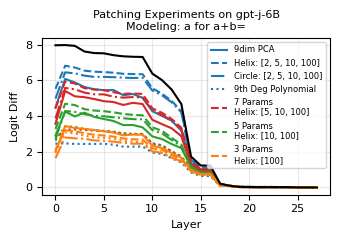

In [58]:

def plot_intervention_results(metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target)

    plt.figure(figsize=(3.5, 2.5))
    toplots = ['pca', 'helix', 'circle', 'poly']
    colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']  # Standard matplotlib colors
    linestyles = ['-', '--', '-.', ':']
    for i, num_params in enumerate([9,7,5,3]):
        fits = get_best(num_params)
        for j, toplot in enumerate(toplots):
            best_fit = fits[toplot]
            values = data[best_fit][metric]
            label = split_helix_type(best_fit)
            if num_params == 9:
                plt.plot(values, color=colors[i], linestyle=linestyles[j], 
                    label=label)
            elif toplot == 'helix':
                plt.plot(values, color=colors[i], linestyle=linestyles[j], 
                    label=f'{num_params} Params\n{label}')
            else:
                plt.plot(values, color=colors[i], linestyle=linestyles[j])
    plt.plot(data['exchange'][metric], color='k', linestyle='-')
    plt.xlabel('Layer')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Patching Experiments on {MODEL_NAME}\nModeling: {target} for a+b=')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'figs/helix_intervention'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/{metric}_by_layer_target_{target}_{MODEL_NAME}.png'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

#MODEL_NAME = 'pythia-6.9b'#'Llama-3.1-8B''gpt-j-6B'#
MODEL_NAME = 'gpt-j-6B'#
plot_intervention_results(metric = 'logit_diff')

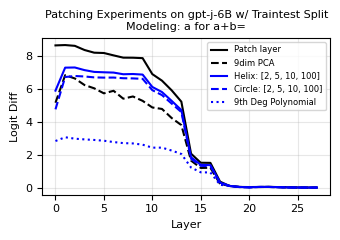

In [13]:
def plot_traintest_intervention_results(metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target, traintest = True)

    plt.figure(figsize=(3.5, 2.5))
    plt.plot(data['exchange'][metric], color='k', linestyle='-', label = 'Patch layer')
    for j, key in enumerate(data.keys()):
        if key == 'exchange':
            continue
        values = data[key][metric]
        label = split_helix_type(key)
        if 'pca' in key:
            plt.plot(values, color='black', linestyle='--', label=label)
        elif 'helix' in key:
            plt.plot(values, color='blue', linestyle='-', label=label)
        elif 'circle' in key:
            plt.plot(values, color='blue', linestyle='--', label=label)
        elif 'poly' in key:
            plt.plot(values, color='blue', linestyle=':', label=label)
    
    plt.xlabel('Layer')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Patching Experiments on {MODEL_NAME} w/ Traintest Split\nModeling: {target} for a+b=')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'figs/helix_intervention'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/{metric}_traintest_layer_target_{target}_{MODEL_NAME}.png'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

#MODEL_NAME = 'gpt-j-6B'
plot_traintest_intervention_results(metric = 'logit_diff')

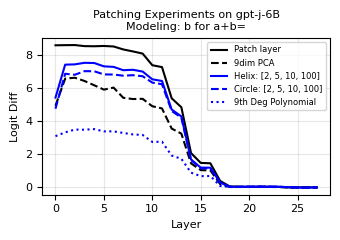

In [11]:
def plot_b_intervention_results(metric = 'logit_diff', target = 'b'):
    data = load_intervention_results(target, traintest = False)

    plt.figure(figsize=(3.5, 2.5))
    plt.plot(data['exchange'][metric], color='k', linestyle='-', label = 'Patch layer')
    for j, key in enumerate(data.keys()):
        if key == 'exchange':
            continue
        values = data[key][metric]
        label = split_helix_type(key)
        if 'pca' in key:
            plt.plot(values, color='black', linestyle='--', label=label)
        elif 'helix' in key:
            plt.plot(values, color='blue', linestyle='-', label=label)
        elif 'circle' in key:
            plt.plot(values, color='blue', linestyle='--', label=label)
        elif 'poly' in key:
            plt.plot(values, color='blue', linestyle=':', label=label)
    plt.xlabel('Layer')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Patching Experiments on {MODEL_NAME}\nModeling: {target} for a+b=')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'figs/helix_intervention'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/{metric}_layer_target_{target}_{MODEL_NAME}.png'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

#MODEL_NAME = 'gpt-j-6B'
plot_b_intervention_results(metric = 'logit_diff')

exchange
pca_9
helix_a_[2, 5, 10, 100]
helix_a_[2, 5, 10, 100]_random


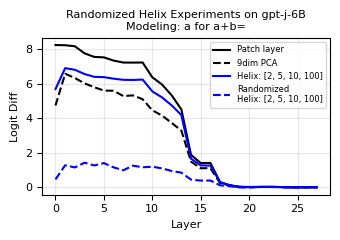

In [41]:

def plot_random_intervention_results(metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target, traintest = False, random = True)

    plt.figure(figsize=(3.5, 2.5))
    plt.plot(data['exchange'][metric], color='k', linestyle='-', label = 'Patch layer')
    for j, key in enumerate(data.keys()):
        print(key)
        if key == 'exchange':
            continue
        values = data[key][metric]
        label = split_helix_type(key)
        if 'pca' in key:
            plt.plot(values, color='black', linestyle='--', label=label)
        elif 'helix' in key:
            linestyle = '-'
            if 'random' in key:
                label = f'Randomized\n{label}'
                linestyle = '--'
            plt.plot(values, color='blue', linestyle=linestyle, label=label)
    
    plt.xlabel('Layer')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Randomized Helix Experiments on {MODEL_NAME}\nModeling: {target} for a+b=')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'figs/helix_intervention'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/{metric}_layer_target_{target}_{MODEL_NAME}_random.png'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

#MODEL_NAME = 'gpt-j-6B'
plot_random_intervention_results(metric = 'logit_diff')

# Plot Random

In [5]:
def find_fit(helix_type, layer, traintest = False):
    save_dir = f'data_{OPERATION}/helix_fit/trained_fit'
    save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}{'_traintest' if traintest else ''}.pkl"
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return data

data = find_fit('helix_a_[2, 5, 10, 100]_random', 20)
data.keys()

dict_keys(['a', 'b', 'a+b', 'predictions_full', 'A_map', 'pca_mean'])